## Time influence analysis on food consumption

In [132]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [6]:
df_transactions = pd.read_csv('dunnhumby/transaction_data.csv', sep = ',')
df_transactions["PAID_PRICE"] = (df_transactions.SALES_VALUE - (df_transactions.RETAIL_DISC.abs() + df_transactions.COUPON_MATCH_DISC.abs()))
df_transactions["PAID_PRICE"] = df_transactions["PAID_PRICE"].clip(lower=0)

### Add time information

To be able to make our time analysis we need to create two new colums. One containing the season of the transaction and another one containing the month. This will allow us to make the analysis monthly or seasonly. 

In [7]:
spring = range(80, 172)
summer = range(172, 264)
fall = range(264, 355)

# TODO: Remove that when merging
start_date = datetime(2010, 3, 24)

def convert_day_to_date(day):
    date = start_date + timedelta(days=day-1)
    return date
#----------------------------------
def convert_date_to_season(date_to_convert):
    doy = date_to_convert.timetuple().tm_yday
    if doy in spring:
        return 'spring'
    elif doy in summer:
        return 'summer'
    elif doy in fall:
        return 'fall'
    else:
        return 'winter'

def num_to_month(shortMonth):
    return {
        "01": "Jan",
        "02": "Feb",
        "03": "Mar",
        "04": "Apr",
        "05": "May",
        "06": "Jun",
        "07": "Jul",
        "08": "Aug",
        "09": "Sep",
        "10": "Oct",
        "11": "Nov",
        "12": "Dec",
    }[shortMonth]

In [8]:
# TODO: Remove when merging
df_transactions["DATE"] = df_transactions.DAY.apply(convert_day_to_date)
# ---------------
df_transactions["SEASON"] = df_transactions.DATE.apply(convert_date_to_season)
df_transactions["MONTH"] = df_transactions.DATE.apply(lambda x: num_to_month(str(x).split("-")[1]))
# To be able to sort by month (January, February, ...)
df_transactions['MONTH'] = pd.Categorical(df_transactions['MONTH'], ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])

For the time analysis we only keep the transactions of 2011 as this is the only full year in the dataset.

In [9]:
## keep only 2011 transactions
df_transactions = df_transactions[(df_transactions["DATE"] >= "2011-01-01") & (df_transactions["DATE"] < "2012-01-01")]

### Make dataframes for the analysis

In [10]:
# All food
df_food_products = pd.read_csv('data/food_products.csv')
df_food_transactions = pd.merge(df_transactions,  df_food_products, on="PRODUCT_ID", how="inner")
# Meat
df_pure_meat_products = pd.read_csv('data/pure_meat_products.csv')
df_meat_products = pd.read_csv('data/meat_products.csv')
meat_products_IDs = df_meat_products.PRODUCT_ID.values
df_meat_transactions = df_food_transactions[df_food_transactions.PRODUCT_ID.isin(meat_products_IDs)]
# Veggies
df_veggies_products = pd.read_csv('data/vegetables_products.csv')
df_veggies_transactions = pd.merge(df_veggies_products, df_food_transactions, on="PRODUCT_ID", how="inner")

### Seasonal analysis of meat consumption

In [11]:
trans_per_season_meat = df_meat_transactions.groupby("SEASON")["household_key"].count().reset_index(name="count").reset_index()
trans_per_season_food = df_food_transactions.groupby("SEASON")["household_key"].count().reset_index(name="count").reset_index()
# Compute the ratio of food sold which is meat in each season
trans_per_season_meat['RATIO'] = trans_per_season_meat['count']/trans_per_season_food['count']

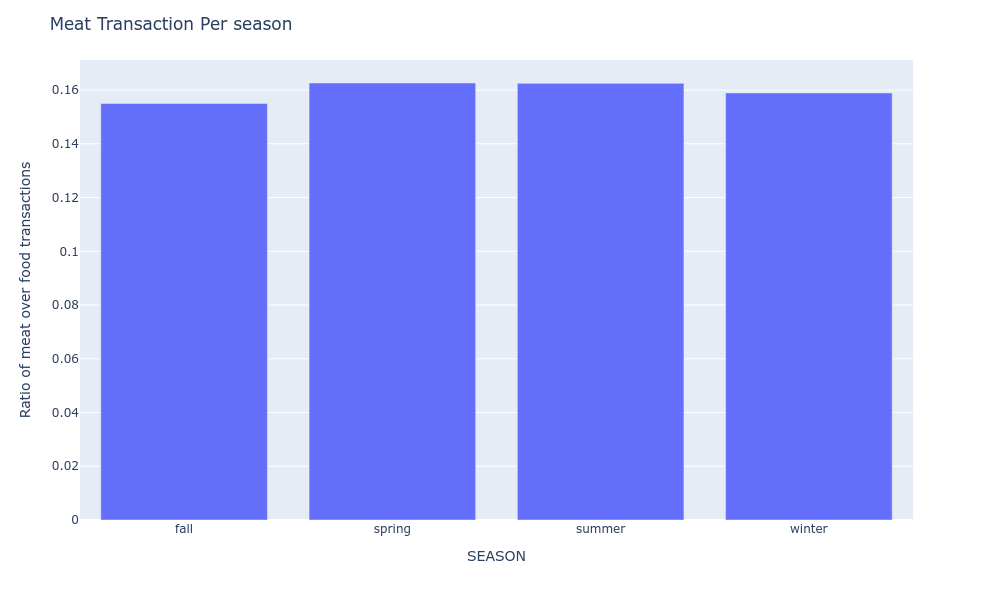

In [27]:
# Plot
fig = px.bar(trans_per_season_meat, x='SEASON', y='RATIO')
fig.update_layout(title="Meat Transaction Per season", yaxis_title="Ratio of meat over food transactions")
fig.show()

We observe that the meat consumption is not varrying accross seasons.

We will now look at the consumptions of the different categories of meat.

In [13]:
# Make a dataframe with the transactions and meat type
df_meat_with_type_transactions = pd.merge(df_meat_transactions, df_pure_meat_products, on="PRODUCT_ID", how="inner")
df_meat_with_type_transactions.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,...,SUB_COMMODITY_DESC_x,CURR_SIZE_OF_PRODUCT_x,Unnamed: 0_y,MANUFACTURER_y,DEPARTMENT_y,BRAND_y,COMMODITY_DESC_y,SUB_COMMODITY_DESC_y,CURR_SIZE_OF_PRODUCT_y,MEAT_TYPE
0,14,31184568098,284,910673,1,3.99,441,-2.0,43,41,...,WINGS (IQF),40 OZ,16256,397,MEAT-PCKGD,National,MEAT - MISC,WINGS (IQF),40 OZ,POULTRY
1,2047,31198209175,284,910673,2,7.98,310,-4.0,1801,41,...,WINGS (IQF),40 OZ,16256,397,MEAT-PCKGD,National,MEAT - MISC,WINGS (IQF),40 OZ,POULTRY
2,14,31198548115,284,910673,3,11.97,441,-6.0,2009,41,...,WINGS (IQF),40 OZ,16256,397,MEAT-PCKGD,National,MEAT - MISC,WINGS (IQF),40 OZ,POULTRY
3,2367,31198856238,285,910673,2,7.98,422,-4.0,1353,41,...,WINGS (IQF),40 OZ,16256,397,MEAT-PCKGD,National,MEAT - MISC,WINGS (IQF),40 OZ,POULTRY
4,1483,31198901477,285,910673,1,3.99,370,-2.0,1442,41,...,WINGS (IQF),40 OZ,16256,397,MEAT-PCKGD,National,MEAT - MISC,WINGS (IQF),40 OZ,POULTRY


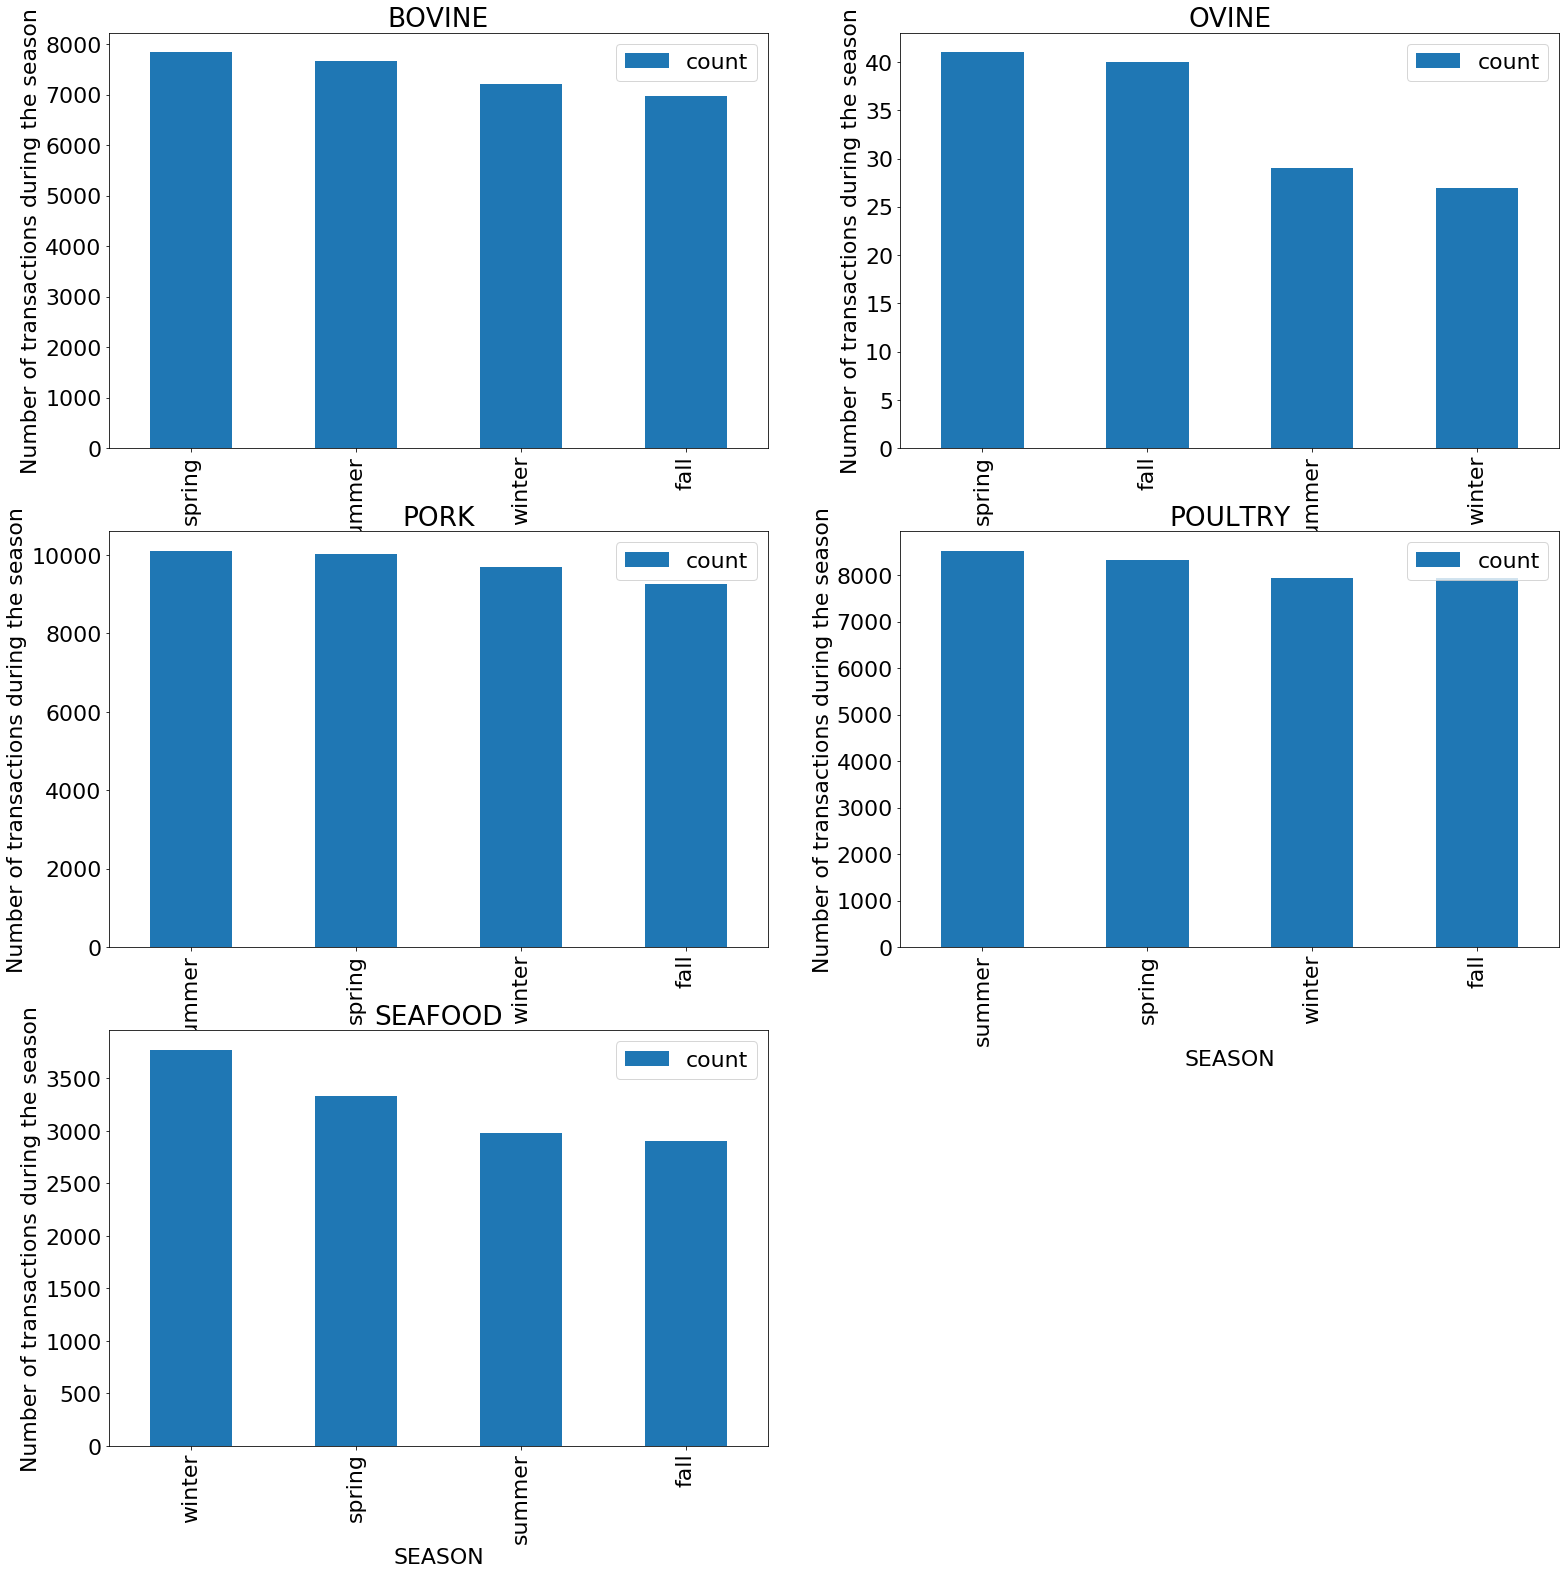

In [133]:
count_type_meat_per_season = df_meat_with_type_transactions.groupby(["SEASON", "MEAT_TYPE"])["household_key"].count().reset_index(name="count")

# Plot 
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(26, 26))
axes[2, 1].set_visible(False)
for i, cat in enumerate(["BOVINE", "OVINE", "PORK", "POULTRY", "SEAFOOD"]):
    df = count_type_meat_per_season[count_type_meat_per_season["MEAT_TYPE"] == cat]
    df.sort_values(by="count", ascending=False).plot.bar(x="SEASON", y="count", ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(cat)
    axes[i//2, i%2].set_ylabel("Number of transactions during the season")    

We do not observe any particular variations for  Bovine, Pork and Poultry. Seafood seems to be more popular in winter than in summer. For the Ovine meat It seems that it is more popular in Spring/Fall than winter but we only have 52 transactions for that meat type so we should be careful with our results.

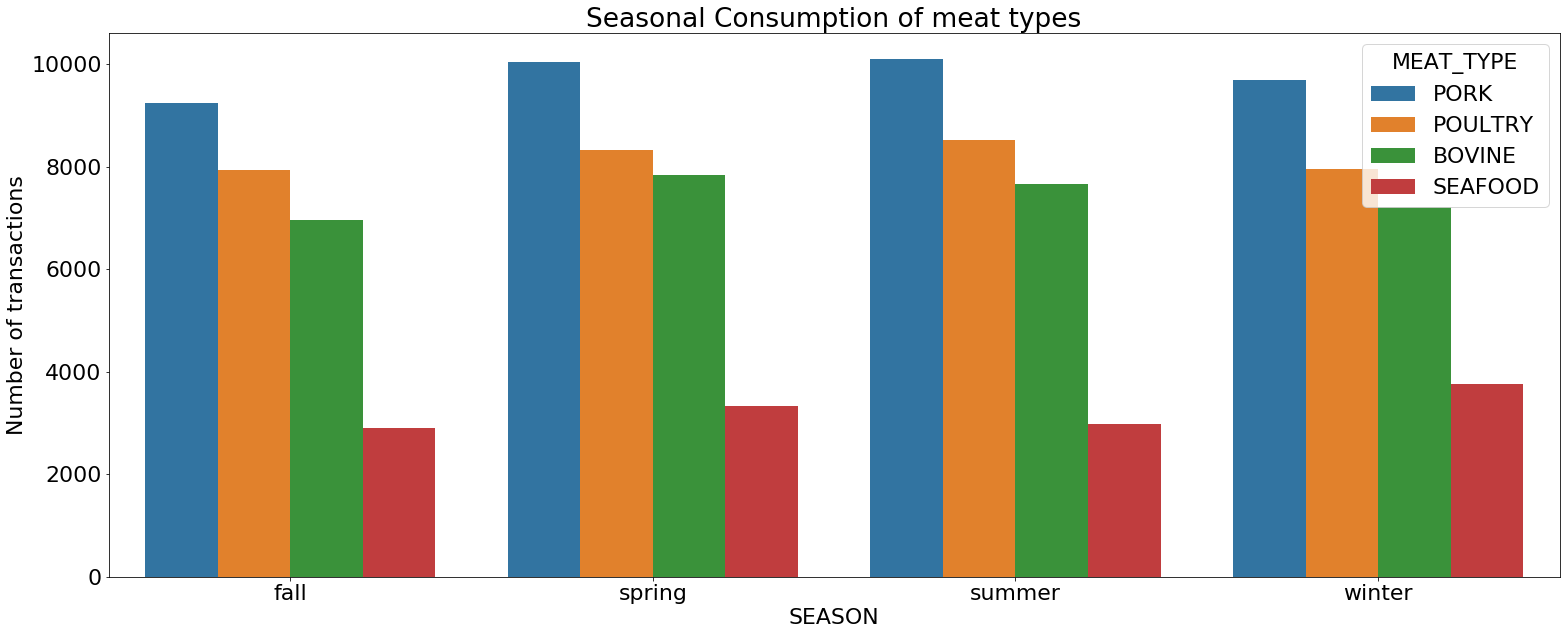

In [134]:
# categories = ["BOVINE", "PORK", "POULTRY", "SEAFOOD"]
categories = ["PORK", "POULTRY", "BOVINE", "SEAFOOD"]

count_type_meat_per_season = df_meat_with_type_transactions.groupby(["SEASON", "MEAT_TYPE"])["household_key"].count().reset_index(name="count")
count_type_meat_per_season = count_type_meat_per_season[count_type_meat_per_season.MEAT_TYPE.isin(categories)]

# Plot
plt.figure(figsize=(26, 10))
fig = sns.barplot(x="SEASON", y="count", hue="MEAT_TYPE", data=count_type_meat_per_season, hue_order=categories)
fig.set_title("Seasonal Consumption of meat types");
fig.set_ylabel("Number of transactions");

### Daily analysis of meat categories consumption

We are also interested in looking at the comsumtion of the meat categories on a daily scale. We do not consider Ovine meat here as the number of transactions is very limited.

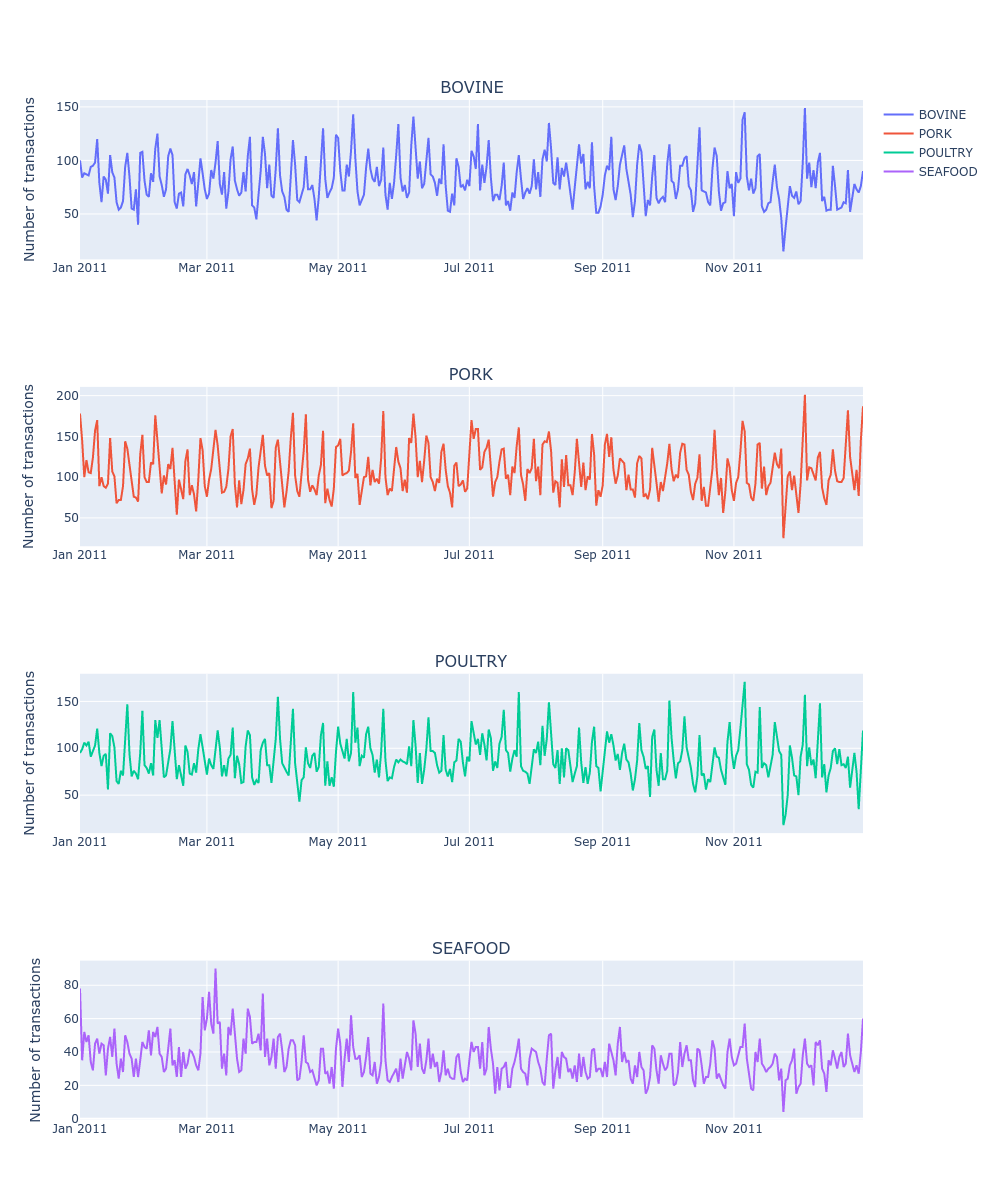

In [101]:

fig = make_subplots(rows=4, cols=1, subplot_titles=categories)

for i, cat in enumerate(categories):
    df = df_meat_with_type_transactions[df_meat_with_type_transactions["MEAT_TYPE"] == cat]
    df = df.groupby("DATE")["household_key"].count().reset_index(name="count").reset_index()
    fig.add_trace(
    go.Scatter(x=df.DATE, y=df["count"], name=cat),
    row=i + 1, col= 1 
    )
    fig.update_yaxes(title_text="Number of transactions", row=i+1, col=1)
fig.update_layout(height=1200)
fig.show()

On the daily scale, we do not observe interesting variations as it is very noisy compared to the seasonal analysis.

### Monthly analysis

We will now analyse the evolution of consumption habits on a month scale. We are intereted in looking at the evolution of food consumption in general but also at the evolution of meat and vegetables.

In [73]:
def filter_and_count_transaction(df, filter_term, column, time_scale):
    filtered_transactions = df[df[column].str.contains(filter_term)]
    trans_per_day = filtered_transactions.groupby(time_scale)["household_key"].count().reset_index(name="count").reset_index()
    return trans_per_day

def add_ratio(df):
    df["RATIO"] = df["count"] / df["count"].sum()
    return df
    
time = "MONTH"
trans_per_time = {}

food_categories= [
    ("MEAT", df_meat_transactions),
    ("FOOD", df_food_transactions),
    ("VEGGIES", df_veggies_transactions),    
]

particular_products = [
    ("TURKEY", df_meat_transactions, "COMMODITY_DESC"),
    ("CHICKEN", df_meat_transactions, "COMMODITY_DESC"),
    ("BEEF", df_meat_transactions, "COMMODITY_DESC"),
    ("PORK", df_meat_transactions, "COMMODITY_DESC"),
    ("SEAFOOD", df_meat_transactions, "COMMODITY_DESC"),
    ("PUMPKIN", df_food_transactions, "SUB_COMMODITY_DESC"),
]

# Food, Meat, Veggies
for food_type, df in food_categories:
    trans_per_time[food_type] = df_meat_transactions.groupby(time)["household_key"]\
                                                    .count().reset_index(name="count")\
                                                    .reset_index()
    trans_per_time[food_type] = add_ratio(trans_per_time[food_type])

# Particular products
for product, df, column in particular_products:
    trans_per_time[product] = filter_and_count_transaction(df, product, column, time)
    trans_per_time[product] = add_ratio(trans_per_time[product])

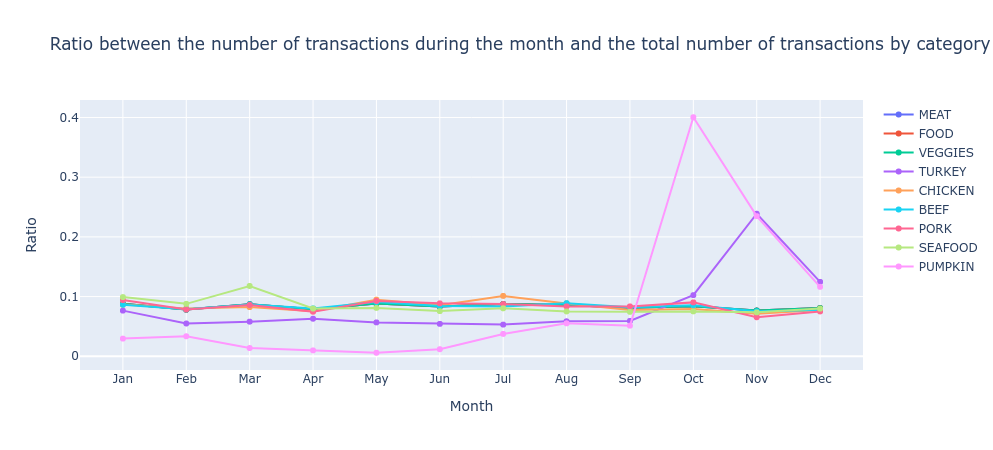

In [80]:
fig = go.Figure()
for name, df in zip(trans_per_time.keys(), trans_per_time.values()):
    fig.add_scatter(x=df[time], y=df['RATIO'], name=name)

fig.update_layout(
    title="Ratio between the number of transactions during the month and the total number of transactions by category",
    yaxis_title="Ratio",
    xaxis_title="Month",
)
fig.show()

We observe that for food, meat and vegetables in general, the monthly consumption does not really vary. However, some variations can be observed when looking at specific types of meats or vegetables. Indeed, looking only at turkeys, we observe a peak in November. This can be explain by Thanksgiving which takes place in November. On the vegetable side, we can obeserve a peak for pumpkins which coincides with Haloween. 